# Data Creation, Exploration and Filtering

In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import math
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import json
from helpers import *
data_folder = './DATA/'

# Historical Timeline
In our analysis we want to see how representation of women in american movies might be impacted by historical events. We therefore need to retrieve a history timeline. We decided to use the timeline on https://www.history.com/topics/womens-history/womens-history-us-timeline since it contains major events related to women's history in the US.

In [2]:
get_history_timeline()

Successfully accessed https://www.history.com/topics/womens-history/womens-history-us-timeline
Timeline saved in DATA/timeline.csv


## Importing raw data

In [3]:
movies_metadata = pd.read_csv(data_folder+'movie.metadata.tsv', header=None, sep='\t', names=['wikipedia_ID','freebase_ID','name','release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genre'], parse_dates=False)
movies_metadata.head(5)

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,languages,countries,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
character_metadata = pd.read_csv(data_folder+'character.metadata.tsv', header=None, sep='\t', names=['wikipedia_ID','freebase_ID','release_date', 'character_name', 'actor_birthday', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name' , 'actor_age','freebase_character_actor_mapID', 'freebase_character_ID', 'freebase_actor_ID' ], parse_dates=False)
character_metadata.head(5)

,wikipedia_ID,freebase_ID,release_date,character_name,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
plot_summaries = pd.read_csv(data_folder+'plot_summaries.txt',sep='\t', header=None, names=['wikipedia_ID', 'plot_summary'] )
plot_summaries.head()

,wikipedia_ID,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Movie dataset: Filtering

**How many movies do we have?**

In [6]:
number_of_data= movies_metadata.count()
number_of_data

wikipedia_ID          81741
freebase_ID           81741
name                  81741
release_date          74839
box_office_revenue     8401
runtime               61291
languages             81741
countries             81741
genre                 81741
dtype: int64

**Where is data mostly missing ?**

In [7]:
proportion_of_each_data = number_of_data/number_of_data['wikipedia_ID']*100
proportion_of_each_data

wikipedia_ID          100.000000
freebase_ID           100.000000
name                  100.000000
release_date           91.556257
box_office_revenue     10.277584
runtime                74.981955
languages             100.000000
countries             100.000000
genre                 100.000000
dtype: float64

We see that the box office column is a column with a lot of missing data, it is only present for 10% of movies. This will not impact our analysis as we are not planning on using the box office as a metric.
One caveat of these results is that an empty list will not be considered as a missing. So for languages, countries and genres this percentages do not really represent the missing data.

Given we will perform our analysis on American movies we will only keep the data for movies from the US

In [8]:
us_movies_metadata = movies_metadata[movies_metadata['countries'].str.contains('United States of America', case=False)].copy()
us_movies_metadata

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,languages,countries,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an..."
...,...,...,...,...,...,...,...,...,...
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana..."
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
81727,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/05p553"": ""Comedy film"", ""/m/02l7c8"": ""Rom..."
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"


How many movies did we keep?

In [9]:
print(us_movies_metadata.count())

wikipedia_ID          34408
freebase_ID           34408
name                  34408
release_date          33197
box_office_revenue     6936
runtime               29509
languages             34408
countries             34408
genre                 34408
dtype: int64


In [10]:
print('Total Number of movies', number_of_data.wikipedia_ID)
print('Number of non-US movies', number_of_data.wikipedia_ID - us_movies_metadata.wikipedia_ID.count())

Total Number of movies 81741
Number of non-US movies 47333


In [11]:
#Let's remove the dictionaries from the countries, the genre and languages of our data
us_movies_metadata['countries'] = us_movies_metadata['countries'].apply(lambda x: list(ast.literal_eval(x).values()))
us_movies_metadata['genre'] = us_movies_metadata['genre'].apply(lambda x: list(ast.literal_eval(x).values()))
us_movies_metadata['languages'] = us_movies_metadata['languages'].apply(lambda x: list(ast.literal_eval(x).values()))

# convert dates to same format and remove movies with unknown movie release dates
us_movies_metadata['release_date'] = us_movies_metadata['release_date'].astype(str)
us_movies_metadata['release_date'] = pd.to_datetime(us_movies_metadata['release_date'],format='mixed', errors='coerce')
us_movies_metadata = us_movies_metadata.dropna(subset=['release_date']).copy()

Let's see what languages we still have in our data

In [12]:
us_movies_metadata["languages"].explode().unique()

array(['English Language', 'Silent film', nan, 'Spanish Language',
       'Greek Language', 'Swahili Language', 'French Language',
       'Standard Mandarin', 'Standard Cantonese', 'Italian Language',
       'Japanese Language', 'American English', 'German Language',
       'Arabic Language', 'Czech Language', 'Slovak Language',
       'Thai Language', 'Portuguese Language', 'Polish Language',
       'Tibetan languages', 'Mandarin Chinese', 'Cantonese',
       'Standard Tibetan', 'Chinese language', 'Swedish Language',
       'Hungarian language', 'Russian Language', 'Dutch Language',
       'Persian Language', 'Irish', 'American Sign Language',
       'Tagalog language', 'Filipino language', 'Xhosa Language',
       'Afrikaans Language', 'Urdu Language', 'Hebrew Language',
       'Tamil Language', 'Latin Language', 'Turkish Language',
       'Hindi Language', 'Serbo-Croatian', 'Croatian language',
       'Serbian language', 'Kannada Language', 'Punjabi language',
       'Bengali Langu

Of interest for us are: English Language, Silent Film, American English, Old English Language (for example Indian English is not very relevant for our analysis, as well as native american languages like Navajo or Hawaiian language). So let us remove any movie that doesn't have English Language, Silent Film, American English, Old English Language, or American Sign Language as one of their language

In [13]:
us_english_movies_metadata = us_movies_metadata[movies_metadata['languages'].str.contains('English Language' or 'Silent Film' or 'American English' or 'Old English Language' or 'American Sign Language', case=False)].copy()

C:\Users\lucil\AppData\Local\Temp\ipykernel_15628\3842193963.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  us_english_movies_metadata = us_movies_metadata[movies_metadata['languages'].str.contains('English Language' or 'Silent Film' or 'American English' or 'Old English Language' or 'American Sign Language', case=False)].copy()


Did we remove any movies by doing that?

In [14]:
print('We had',us_movies_metadata.wikipedia_ID.count(), 'movies in our U.S data frame')
print('We now have', us_english_movies_metadata.wikipedia_ID.count(), 'in our English US data frame')
print('So there are',us_movies_metadata.wikipedia_ID.count()-us_english_movies_metadata.wikipedia_ID.count(), 'movies that were from the US but not in any of the languages we decided to consider.')
print('We also see that in the movies we removed, there are', np.sum(us_movies_metadata['languages'].apply(lambda x: len(x)==0)), 'movies that lack languages. For the next milestone we will thus find out the languages of these movies to complete the dataset.')

We had 33197 movies in our U.S data frame
We now have 29830 in our English US data frame
So there are 3367 movies that were from the US but not in any of the languages we decided to consider.
We also see that in the movies we removed, there are 3022 movies that lack languages. For the next milestone we will thus find out the languages of these movies to complete the dataset.


**Now let us have a look at the genres we have in our dataset**

In [15]:
us_english_movies_metadata["genre"].explode().unique()

array(['Thriller', 'Science Fiction', 'Horror', 'Adventure',
       'Supernatural', 'Action', 'Space western', 'Mystery',
       'Biographical film', 'Drama', 'Crime Drama', 'Short Film',
       'Silent film', 'Indie', 'Black-and-white', 'Comedy', 'Musical',
       'Romantic comedy', 'Ensemble Film', 'Comedy-drama',
       'Romantic drama', 'Romance Film', "Children's/Family", 'Fantasy',
       'Family Film', "Children's Fantasy", 'Future noir',
       'Erotic thriller', 'Film adaptation', 'Crime Fiction',
       'Coming of age', 'Marriage Drama', 'Western', 'Fan film',
       'Black comedy', 'War film', 'Epic', 'Biopic [feature]',
       'Historical Epic', 'Action/Adventure', 'Costume drama',
       'Historical fiction', 'Culture & Society', 'Biography',
       'Documentary', 'Christmas movie', 'Television movie',
       'Action Comedy', 'Cult', 'Blaxploitation', 'Martial Arts Film',
       'Epic Western', 'Softcore Porn', 'Sexploitation', 'Parody',
       'B-movie', 'Zombie Film', 'C

As we can see we have a massive amount (342) of genres, so at some point we will need to filter or chose certain genres to analyze.


**Plot of the number of movies per year**

In [16]:
#us_english_movies_metadata['release_date'] = pd.to_datetime(us_english_movies_metadata['release_date'],format='mixed', errors='coerce')
#us_english_movies_metadata

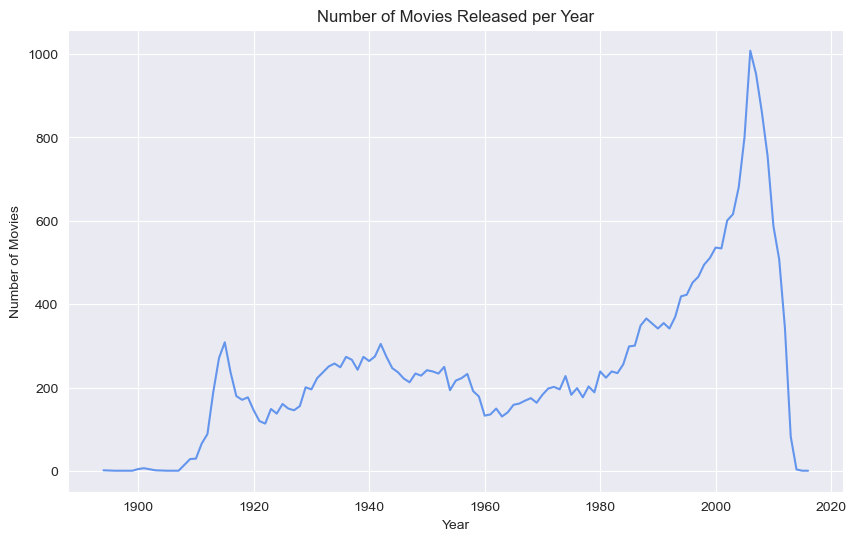

In [17]:
# Group movies by release year
movies_grouped_by_year = us_english_movies_metadata.groupby(us_english_movies_metadata['release_date'].dt.year)

#number of movies per year
number_movies_per_year = movies_grouped_by_year.size()

plt.figure(figsize=(10, 6))
number_movies_per_year.plot(kind='line', color = 'cornflowerblue')
plt.title('Number of Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

We can see on this plot that before 1912 we have very little movies. We will thus only keep movies from 1912 and later years.

In [18]:
us_english_movies_metadata = us_english_movies_metadata[us_english_movies_metadata['release_date'].dt.year >= 1912]

Let us merge this movies dataframe with the synopses

In [19]:
us_english_movies_synopsis = pd.merge(us_english_movies_metadata, plot_summaries, how='left', on = 'wikipedia_ID')

In [20]:
us_english_movies_synopsis

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,languages,countries,genre,plot_summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",NaN
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",NaN
4,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",NaN
...,...,...,...,...,...,...,...,...,...,...
29662,34474142,/m/0cpy07r,Frontier Fury,1943-06-24,NaN,55.0,[English Language],[United States of America],[Western],NaN
29663,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]",Havoc is wrought on the inhabitants of a small...
29664,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946-01-01,NaN,105.0,[English Language],[United States of America],"[Comedy film, Romance Film, Musical]",NaN
29665,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...


Do we have a lot of missing summaries?

In [21]:
missing_plot = us_english_movies_synopsis['plot_summary'].isna().sum()
number_of_movies = len(us_english_movies_synopsis['plot_summary'])
print('We only have', number_of_movies- missing_plot, 'movies out of',number_of_movies, "with a summary, which means we only have 60.59% of the movies with the plotline. However, the plot summary analysis might be too costly to run on a lot of summaries. It might therefore be reasonable not to complete the missing plot summaries." )

We only have 18805 movies out of 29667 with a summary, which means we only have 60.59% of the movies with the plotline. However, the plot summary analysis might be too costly to run on a lot of summaries. It might therefore be reasonable not to complete the missing plot summaries.


# Character Dataset: Filtering

Let's start by checking the completeness of the character dataset:

In [22]:
number_of_data_character= character_metadata.count()
proportion_of_each_data_character = number_of_data_character/number_of_data_character['wikipedia_ID']*100
proportion_of_each_data_character

wikipedia_ID                      100.000000
freebase_ID                       100.000000
release_date                       97.782186
character_name                     42.779512
actor_birthday                     76.447237
actor_gender                       89.879712
actor_height                       34.354260
actor_ethnicity                    23.533458
actor_name                         99.727516
actor_age                          64.915936
freebase_character_actor_mapID    100.000000
freebase_character_ID              42.781731
freebase_actor_ID                  99.819158
dtype: float64

The data seems pretty complete regarding the release date of the movies, actor's gender and actor's age. Nevertheless, we need  to complete the dataset with more character's name to be able to analyze deeper the personnas associated with them and use this result in our analysis. getting also more data on actors' ethnicity would also be of choice as this will allow us to extend our analysis to other minorities such as people of color.

In [23]:
# remove unknown release dates
character_metadata = character_metadata.dropna(subset='release_date')
# convert the release_date to a date format (YYYY/MM/DD but any date that initially only has a year will be converted to YYYY/01/01)
character_metadata['release_date'] = character_metadata['release_date'].astype(str)
#character_metadata['actor_birthday'] = character_metadata['actor_birthday'].astype(str)
character_metadata['release_date'] = pd.to_datetime(character_metadata['release_date'], format = 'mixed', errors='coerce').dt.year
#character_metadata['actor_birthday'] = pd.to_datetime(character_metadata['actor_birthday'], format = 'mixed', errors='coerce').dt.year

First we will only keep the characters related to the movies we previously filtered

In [24]:
us_movie_mask = character_metadata['wikipedia_ID'].isin(us_english_movies_metadata['wikipedia_ID'])
character_metadata = character_metadata[us_movie_mask]

Let's filter the character metadata to remove actors with a gender differing from F or M. However, let's first explore the values that "gender" take.

In [25]:
# Check values in the "actor_gender" column
character_metadata.loc[character_metadata.actor_gender.isna(), "actor_gender"] = "NA"
display(character_metadata.groupby("actor_gender").count().actor_name)

actor_gender
F      67647
M     141440
NA     17185
Name: actor_name, dtype: int64

As expected, actor's gender is either F (female), M (male) or NA (not mentionned). Nevertheless, this check was necessary in order to make sure no one identified as non-binary for example. Let's now remove the actors with NA as gender as well as all the characters in movies that have no release date as our analysis is related to time.


In [26]:
# remove any value that is not "F" or "M" in the "gender" column or the character metadata, keeps the rest
character_metadata_noNA_gender = character_metadata[character_metadata["actor_gender"].isin(["F", "M"])].copy()
# drop the characters in movies with no release date
character_metadata_noNA_genderYear = character_metadata_noNA_gender.dropna(subset=['release_date']).copy()

display(character_metadata_noNA_genderYear)
print('From the original character dataset, we dropped ', character_metadata.shape[0]-character_metadata_noNA_genderYear.shape[0], 'characters either because the movie had no release date or the gender of the actor was not specified, out of ', character_metadata.shape[0], 'characters initially.')

,wikipedia_ID,freebase_ID,release_date,character_name,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001.0,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001.0,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001.0,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450638,30553937,/m/0g9ts5h,1998.0,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,/m/0jxtsx5,/m/0jxtsx8,/m/0jxtsxh
450639,30553937,/m/0g9ts5h,1998.0,Julia,1975-10-10,F,NaN,NaN,Natalie Ramsey,22.0,/m/0jxtsw7,/m/0jxtswb,/m/027dt0m
450640,7223293,/m/0kv0xs,1925.0,NaN,1894-02-28,M,NaN,NaN,Sid Smith,NaN,/m/02vcw0s,NaN,/m/02qrq5t
450641,9971909,/m/02pygw1,1972.0,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5


From the original character dataset, we dropped  17841 characters either because the movie had no release date or the gender of the actor was not specified, out of  226929 characters initially.


### Merging personas with character dataset

In [27]:
# Read the data from the text file, comma is the delimiter
personnas_metadata = pd.read_csv(data_folder + 'tvtropes.clusters.txt', names=['personnas', 'data'], header=None, sep='\t')

# Replace single quotes with a placeholder character, to avoid error in parsing
personnas_metadata['data'] = personnas_metadata['data'].str.replace("'", "@@QUOTE@@")
personnas_metadata['data'] = personnas_metadata['data'].apply(lambda x: x.replace("@@QUOTE@@", "'"))

# Function to load JSON strings
def json_loads(x):
    try:
        return json.loads(x)
    except (ValueError, SyntaxError):
        print(f"Error decoding JSON: {x}")
        return None

# Parse the JSON-like strings and split them into separate columns
personnas_metadata['data'] = personnas_metadata['data'].apply(json_loads)
personnas_metadata = pd.concat([personnas_metadata.drop('data', axis=1), personnas_metadata['data'].apply(pd.Series)], axis=1)

#Rename the id column so it matches  with the character dataset to be able to merge (information from the README file) --> maps the actor with its character in the character metadata dataset
personnas_metadata.rename(columns={'id': 'freebase_character_actor_mapID'}, inplace=True)

display(personnas_metadata)

,personnas,char,movie,freebase_character_actor_mapID,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


Let's merge this data with the character data we have on freebase_character_actor_mapID as this relates the personnas with the actor and the character they play in a specific movie.

In [28]:
# only add the column personnas to the characters dataset
character_metadata_noNA_genderYear_personnas = character_metadata.merge(personnas_metadata[['freebase_character_actor_mapID', 'personnas']],on=["freebase_character_actor_mapID"],how="left").copy()

display(character_metadata_noNA_genderYear_personnas)

,wikipedia_ID,freebase_ID,release_date,character_name,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID,personnas
0,975900,/m/03vyhn,2001.0,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,NaN
3,975900,/m/03vyhn,2001.0,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001.0,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226975,30553937,/m/0g9ts5h,1998.0,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,/m/0jxtsx5,/m/0jxtsx8,/m/0jxtsxh,NaN
226976,30553937,/m/0g9ts5h,1998.0,Julia,1975-10-10,F,NaN,NaN,Natalie Ramsey,22.0,/m/0jxtsw7,/m/0jxtswb,/m/027dt0m,NaN
226977,7223293,/m/0kv0xs,1925.0,NaN,1894-02-28,M,NaN,NaN,Sid Smith,NaN,/m/02vcw0s,NaN,/m/02qrq5t,NaN
226978,9971909,/m/02pygw1,1972.0,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,NaN


Finally, we will add the name of the movies to the dataset to facilitate merges with datasets that do not have wikipedia ID.

In [29]:
character_metadata_noNA_genderYear_personnas = pd.merge(character_metadata_noNA_genderYear_personnas, movies_metadata[['wikipedia_ID', 'name']], how='left', on='wikipedia_ID')

# Complementing the dataset after 2010
The provided dataset does not contain information on recent movies. We thus decided to complement it using IMDB data to be able to also perform our analysis in recent years. We have two main datasets to complete: the movie dataset and the character dataset. To do so, we used the data available on https://datasets.imdbws.com/ and the library Cinemagoer that can retrieve information on IMDB.

### A) Complementing movie data
To complete the movie dataset we used the following folders need to be downloaded from https://datasets.imdbws.com/, unzipped and placed in the /DATA folder:
- title.basics.tsv.gz
- title.akas.tsv.gz

However, these files are missing a lot information that we need for our analysis (plot summaries, countries, languages). We will therefore also use the library Cinemagoer to retrieve these information. In order to not have too many useless requests to IMDB through Cinemagoer, we use the datasets title.basics and titles.akas to get a list of ID of movies we are interested in.

In [30]:
titles_dataset = pd.read_csv(data_folder + 'title.basics.tsv/data.tsv', sep='\t')
movie_IDs = filter_titles_IDs(titles_dataset)

C:\Users\lucil\AppData\Local\Temp\ipykernel_15628\1741907766.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_dataset = pd.read_csv(data_folder + 'title.basics.tsv/data.tsv', sep='\t')


In [31]:
print(len(movie_IDs)) # we still have 204'389

204389


Taking all of these movies from IMDB would take too much time. These IDs contain movies from a lot of different countries and we are only interested in american movies. We do not have the 'country' information in the downloaded datasets but we do have the 'original title' and the 'american title' in the title.akas dataset. We will use this dataset to find movies in which the original title is the same as the american one. Thus we can already remove some movies that we know are probably not american. We will of course keep a lot of non-american movies, but we can filter those out later.


In [32]:
titles_akas_dataset = pd.read_csv(data_folder + 'title.akas.tsv/data.tsv', sep='\t')
original_titles = titles_akas_dataset[titles_akas_dataset['isOriginalTitle']==1]['title']
# get all only the lines where the title is the same as the original title
titles_akas_dataset_filtered = titles_akas_dataset[titles_akas_dataset['title'].isin(original_titles)]
# get only the movies where the US title is the same as the original title
titles_akas_dataset_filtered = titles_akas_dataset_filtered[titles_akas_dataset_filtered['region'] == 'US']

C:\Users\lucil\AppData\Local\Temp\ipykernel_15628\1011026718.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_akas_dataset = pd.read_csv(data_folder + 'title.akas.tsv/data.tsv', sep='\t')


In [33]:
# get only IDs that are in both datasets
common_ids = titles_akas_dataset_filtered[titles_akas_dataset_filtered['titleId'].isin(movie_IDs)]
common_ids = common_ids['titleId'].drop_duplicates()
print(len(common_ids)) # 39'595 movies left

39595


We will now retrieve information of these 39'595 movies directly from IMDB using Cinemagoer

!! THE FOLLOWING CELL TAKES A LONG TIME TO RUN !!
Since it has already been run once and the data was saved, there is no need to run it anymore and it is thus commented.

In [34]:
#get_IMDB_movies_data(common_ids)

We filter the movies to only keep american movies in English from 2010-2022. Note that filter according to the release year again, even thought the movies to get on IMDB were already filtered according to their release date. That is because both datasets did not have necessarily the same release date for the same movie and thus a second filtering is necessary.

In [35]:
IMDB_movie_data = pd.read_csv(data_folder + 'IMDB_movies_2010-2022.csv')
IMDB_movie_data_filtered = filter_IMDB_movie_dataset(IMDB_movie_data)

In [36]:
IMDB_movie_data_filtered

,IMDB_ID,name,release_date,languages,countries,genre,plot_summary
1,tt0112502,Bigfoot,2017,['English'],['United States'],"['Horror', 'Thriller']","['A story of a man who, after having been thro..."
2,tt0172182,Blood Type,2018,['English'],['United States'],"['Comedy', 'Drama', 'Mystery']","['During a frantic police car chase, a fleeing..."
3,tt0195933,Mysteries,2019,['English'],['United States'],NaN,NaN
4,tt0293429,Mortal Kombat,2021,"['English', 'Japanese', 'Chinese']",['United States'],"['Action', 'Adventure', 'Fantasy', 'Sci-Fi', '...","[""MMA fighter Cole Young seeks out Earth's gre..."
5,tt0297400,Snowblind,2015,['English'],"['United States', 'Canada']","['Crime', 'Drama']","['Revealing the entrepreneurial ingenuity, par..."
...,...,...,...,...,...,...,...
39579,tt9913056,Swarm Season,2019,['English'],['United States'],['Documentary'],"[""On the remote volcanic island of Hawaii, 10-..."
39580,tt9913288,Letters,2020,['English'],['United States'],['Drama'],"[""Charlie Porter is an ordinary man. He leads ..."
39586,tt9914522,The Holden Family Plan,2019,['English'],['United States'],"['Drama', 'Family']","[""When Mackenzie Holden's sister and brother i..."
39587,tt9914582,However Long,2019,['English'],['United States'],['Documentary'],['Documentary following four women with incura...


We now have a datasets containing all the needed information on movies from 2010-2022. We just need to merge it with the provided dataset.

In [37]:
provided_data = us_english_movies_synopsis
# change the release date to just the year to be able to merge more easily and convert it to the same format of the other df
provided_data['release_date'] = provided_data['release_date'].dt.year
# country and languages are not needed anymore
provided_data = provided_data.drop(columns=['languages', 'countries'])
IMDB_movie_data_filtered = IMDB_movie_data_filtered.drop(columns=['languages', 'countries'])
# put movie names to lower case in both datasets so that they are recognised as the same movie name even if there are differences in the case
provided_data['name'] = name_to_lowercase(provided_data, 'name')
IMDB_movie_data_filtered['name'] = name_to_lowercase(IMDB_movie_data_filtered, 'name')

Since we do not have a unique identifier for both datasets (one has wikipedia ID, the other IMDB ID), we use the columns 'name' and 'release_date' to do the merge. However, it can happen that two movies with the same name are released in the same year. In the case where only one of the movie is present in a dataset and both are present in the other, the merge could be wrong and assign an ID of the wrong movie. After the merge, we will thus drop all duplicated movie IDs. This will make us loose some films but will ensure that our merge does not contain mistakes.

In [38]:
# merge IMDB and provided dataset
movie_data = pd.merge(provided_data, IMDB_movie_data_filtered, on=['name', 'release_date'], how='outer').copy()
duplicated_cols = ['plot_summary', 'genre']
movie_data = remove_duplicated_columns(movie_data, duplicated_cols)
# remove duplicated IDs except the ones that contain NaNs in one of the ID
movie_data = movie_data[~movie_data.duplicated(subset='wikipedia_ID', keep=False) | movie_data['wikipedia_ID'].isnull()]
movie_data = movie_data[~movie_data.duplicated(subset='IMDB_ID', keep=False) | movie_data['IMDB_ID'].isnull()]

In [39]:
movie_data

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID
0,975900.0,/m/03vyhn,ghosts of mars,2001,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",NaN
1,3196793.0,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000,NaN,95.0,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN
2,13696889.0,/m/03cfc81,the gangsters,1913,NaN,35.0,"[Short Film, Silent film, Indie, Black-and-whi...",NaN,NaN
3,10408933.0,/m/02qc0j7,alexander's ragtime band,1938,3600000.0,106.0,"[Musical, Comedy, Black-and-white]",NaN,NaN
4,175026.0,/m/017n1p,sarah and son,1930,NaN,86.0,"[Drama, Black-and-white]",NaN,NaN
...,...,...,...,...,...,...,...,...,...
53552,NaN,NaN,swarm season,2019,NaN,NaN,['Documentary'],"[""On the remote volcanic island of Hawaii, 10-...",tt9913056
53553,NaN,NaN,letters,2020,NaN,NaN,['Drama'],"[""Charlie Porter is an ordinary man. He leads ...",tt9913288
53554,NaN,NaN,the holden family plan,2019,NaN,NaN,"['Drama', 'Family']","[""When Mackenzie Holden's sister and brother i...",tt9914522
53555,NaN,NaN,however long,2019,NaN,NaN,['Documentary'],['Documentary following four women with incura...,tt9914582


We can now plot again the number of movies per year in our dataset to see if it indeed is completed after 2010

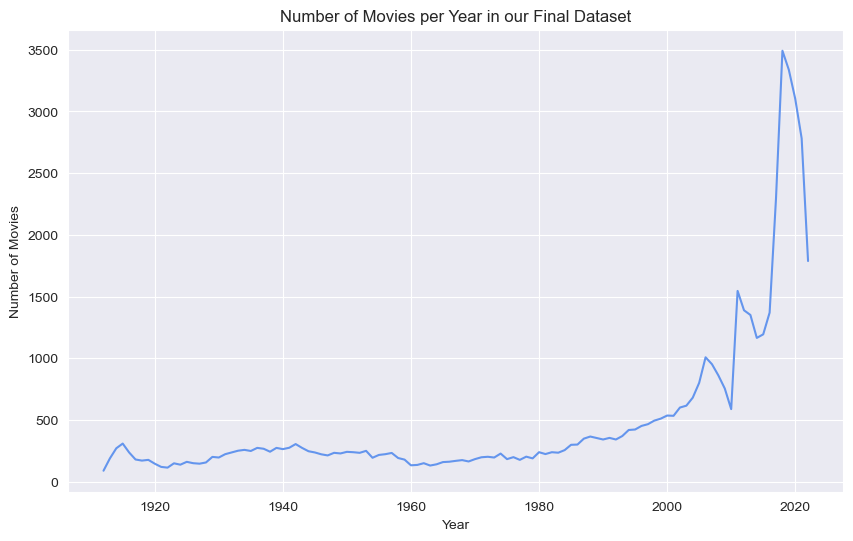

In [40]:
# Group movies by release year
movies_grouped_by_year = movie_data.groupby(movie_data['release_date'])

#number of movies per year
number_movies_per_year = movies_grouped_by_year.size()

plt.figure(figsize=(10, 6))
number_movies_per_year.plot(kind='line', color = 'cornflowerblue')
plt.title('Number of Movies per Year in our Final Dataset')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

We see that we have many more movies from 2010 to 2022 than in previous years since we complemented the dataset with more than 20'000 movies in just 10 years. This should not be a problem since we will conduct our analysis per year and thus our results will be always be normalized with the number of movies for each year.

We now have a data sets containing movies until 2022 that is ready for our analysis! We will save it so that we do not have to re-run this part of the code and can easily use it in other notebooks.


In [41]:
movie_data.to_csv(data_folder + 'movie_data.csv', index=False)

### B) Complementing characters' data
To complete the character dataset the following folders need to be downloaded from https://datasets.imdbws.com/, unzipped and placed in the /DATA folder:
- title.principals.tsv.gz
- name.basics.tsv.gz

In [42]:
# load characters info
characters_data = pd.read_csv(data_folder + 'title.principals.tsv/data.tsv', sep='\t')
IMDB_ids = IMDB_movie_data_filtered['IMDB_ID']
# only keep characters of the filtered movies
characters_data_filtered = clean_IMDB_character_dataset(characters_data, IMDB_ids)

C:\Users\lucil\OneDrive\Documents\EPFL\MA3\ADA\ada-2023-project-badabob\helpers.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_data.loc[characters_data['category'] == 'actor', 'actor_gender'] = 'M'


In [43]:
# load actors info
actors_data = pd.read_csv(data_folder + 'name.basics.tsv/data.tsv', sep='\t')
# remove useless columns
actors_data = actors_data.drop(columns=['deathYear', 'primaryProfession', 'knownForTitles'])

We now need to merge all the information we have on the characters and the actors. There are some information we still need to add to the dataframe: release date, actor age, movie name. These will be added by merging with the movie dataset created above.

In [44]:
# merge actor data and movie data on character data
IMDB_characters_data = merge_datasets_characters(characters_data_filtered, actors_data, IMDB_movie_data_filtered)
IMDB_characters_data.loc[IMDB_characters_data['character_name'] == '\\N', 'character_name'] = None

In [45]:
IMDB_characters_data

,IMDB_ID,actor_IMDB_ID,character_name,actor_gender,actor_name,name,release_date,actor_age
0,tt0172182,nm0182661,Bum Joe,M,Nicolas Coster,blood type,2018,85.0
1,tt0172182,nm0500098,Tiffanie,F,Hudson Leick,blood type,2018,49.0
2,tt0172182,nm0090981,Chad,M,Wolfgang Bodison,blood type,2018,52.0
3,tt0172182,nm0001730,Mrs. Dow,F,Deborah Shelton,blood type,2018,70.0
4,tt0293429,nm1167985,Cole Young,M,Lewis Tan,mortal kombat,2021,NaN
...,...,...,...,...,...,...,...,...
76655,tt9914522,nm7997361,Evan,M,Caleb Silvers,the holden family plan,2019,24.0
76656,tt9914522,nm2246717,Mackenzie,F,Bethany Hazelitt,the holden family plan,2019,29.0
76657,tt9914522,nm10172541,Evan's dad,M,Joshua Bootz,the holden family plan,2019,NaN
76658,tt9914522,nm10537291,Todd,M,Vince Camaj,the holden family plan,2019,NaN


We can now merge this IMDB character dataset with the provided character dataset

In [46]:
provided_characters = character_metadata_noNA_genderYear_personnas

In [47]:
#first put all strings in lower case
provided_characters['character_name'] = name_to_lowercase(provided_characters, 'character_name')
provided_characters['actor_name'] = name_to_lowercase(provided_characters, 'actor_name')
provided_characters['name'] = name_to_lowercase(provided_characters, 'name')
IMDB_characters_data['character_name'] = name_to_lowercase(IMDB_characters_data, 'character_name')
IMDB_characters_data['actor_name'] = name_to_lowercase(IMDB_characters_data, 'actor_name')
IMDB_characters_data['name'] = name_to_lowercase(IMDB_characters_data, 'name')

Since we do not have the wikipedia IDs of the movie scraped on IMDB and the IMDB IDs of the movies in the original dataset, we cannot do a merge on a unique ID. We thus perform the merge on multiple columns (movie name, actor name and release date). We decided to not use the character name column since it would assume that, for the same character, the character name is the same in both datasets. This is not true. Sometimes the characters are identified only by their first names or only by their last names, sometimes by their nicknames and sometimes by their first and last names in both datasets. Additionally, in the provided dataset, sometimes a character is present twice because it has 2 different names and this is not the case in the IMDB dataset. After the merge, when we have information on characters from both datasets, we will keep only the character name of the IMDB dataset and then remove duplicates. This should remove characters that are doubled in the provided dataset because they have two different names.

One caveat of this merge method is that the merge will not be accurate if one actor plays two different characters in the same movie or in a movie of the same year with the same name. However, we are assuming that this event is rare enough and that we have enough data so that it doesn't influence our analysis too much.

In [49]:
# merge datasets
characters_data = pd.merge(provided_characters, IMDB_characters_data, on=['name', 'actor_name', 'release_date'], how='outer').copy()
# remove columns that were duplicated
duplicated_cols = ['actor_gender', 'actor_age']
characters_data= remove_duplicated_columns(characters_data, duplicated_cols)
characters_data = remove_duplicated_columns(characters_data, ['character_name'], col_to_keep='_y', col_to_delete='_x')
# remove potential duplicates but keep NaNs
characters_data = characters_data.drop_duplicates(subset=['character_name', 'actor_name', 'release_date', 'name'])

In [50]:
characters_data

,wikipedia_ID,freebase_ID,release_date,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID,personnas,name,IMDB_ID,actor_IMDB_ID,character_name
0,975900.0,/m/03vyhn,2001.0,1958-08-26,F,1.620,NaN,wanda de jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,ghosts of mars,NaN,NaN,akooshay
1,975900.0,/m/03vyhn,2001.0,1974-08-15,F,1.780,/m/044038p,natasha henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,ghosts of mars,NaN,NaN,lieutenant melanie ballard
2,975900.0,/m/03vyhn,2001.0,1969-06-15,M,1.727,/m/0x67,ice cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,NaN,ghosts of mars,NaN,NaN,desolation williams
3,975900.0,/m/03vyhn,2001.0,1967-09-12,M,1.750,NaN,jason statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,ghosts of mars,NaN,NaN,sgt jericho butler
4,975900.0,/m/03vyhn,2001.0,1977-09-25,F,1.650,NaN,clea duvall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,ghosts of mars,NaN,NaN,bashira kincaid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302681,NaN,NaN,2019.0,NaN,M,NaN,NaN,caleb silvers,24.0,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm7997361,evan
302682,NaN,NaN,2019.0,NaN,F,NaN,NaN,bethany hazelitt,29.0,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm2246717,mackenzie
302683,NaN,NaN,2019.0,NaN,M,NaN,NaN,joshua bootz,NaN,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm10172541,evan's dad
302684,NaN,NaN,2019.0,NaN,M,NaN,NaN,vince camaj,NaN,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm10537291,todd


We can now plot the number of characters per year to ensure we have data for every year

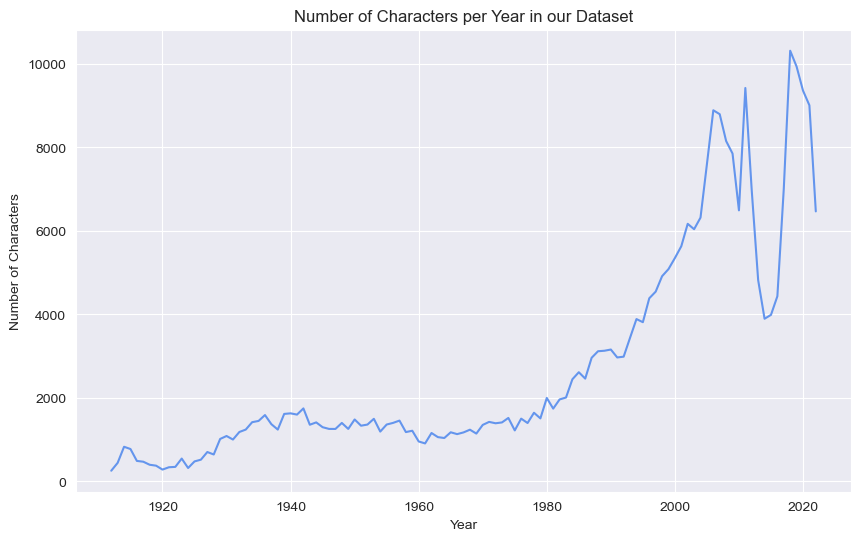

In [51]:
# Group movies by release year
char_grouped_by_year = characters_data.groupby(characters_data['release_date'])

#number of movies per year
number_char_per_year = char_grouped_by_year.size()

plt.figure(figsize=(10, 6))
number_char_per_year.plot(kind='line', color = 'cornflowerblue')
plt.title('Number of Characters per Year in our Dataset')
plt.xlabel('Year')
plt.ylabel('Number of Characters')
plt.grid(True)
plt.show()

Similarly to what we observe in the movie dataset, we also have many more characters per year from 2010 and later. Again, this should not be a problem since we conduct our analysis separately for each year.


We now have a dataset of characters in US movies from 1910 to 2022 ! We will save it so that we do not need to re-run this part of the notebook again

In [52]:
characters_data.to_csv(data_folder + 'characters_data.csv', index=False)

## First Analysis of characters

**What's the proportion of female actors in movies per year?**
We wonder if the proportion of female actors' increase over the years, which is what we would expect.

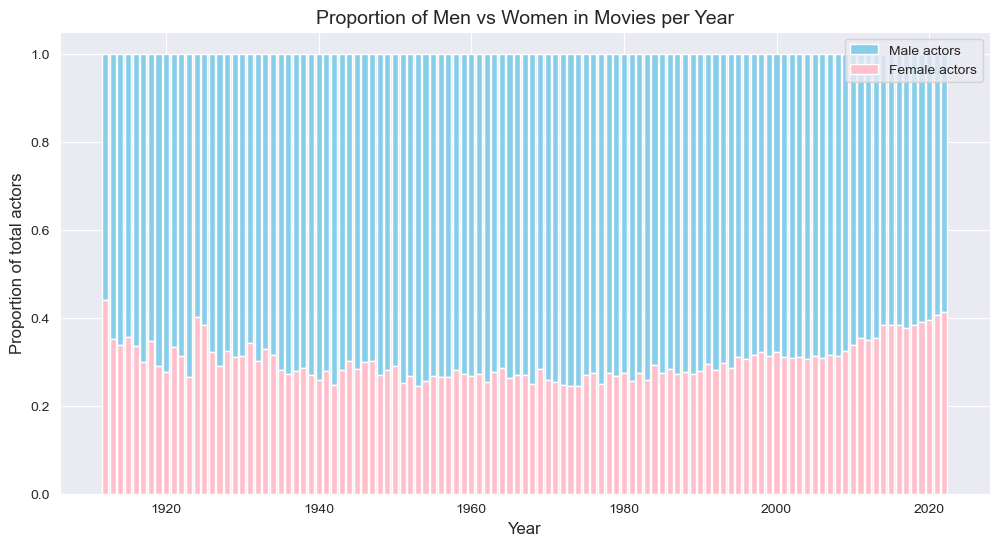

In [53]:
# group the movies by year
#characters_data['release_date'] = pd.to_datetime(characters_data['release_date'])
characters_grouped_by_year = characters_data.groupby(characters_data['release_date'])

# Calculate the proportion of men and women per year
proportion_female = characters_grouped_by_year['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male = 1 - proportion_female

# Plotting the proportion of men vs women per year as a stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(proportion_male.index, proportion_male.values, bottom=proportion_female.values, label='Male actors', color='skyblue')
plt.bar(proportion_female.index, proportion_female.values, label='Female actors', color='pink')
plt.title('Proportion of Men vs Women in Movies per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of total actors', fontsize=12)
plt.legend()
plt.show()

Interestingly, the proportion of women over the decades stayed fairly constant, close to 40%. This constrasts with what we expected as we would think that women representation would get better over the years.  **Questions for the group: should we remove data from before 1910 as so low that doesn't make sense?**

Nevertheless, this result doesn't mean that each movie has approximately 40% of women in their cast. This result might be biased by movies that have an extremely low/high proportion of women versus movies that have a balanced actors cast. To determine if that is the case, let's plot the proportion of movies per year that have 0-25% women, 25-50%, 50-75% or 75-100% women. Are female actors represented equally in every movies or is there a discrepency between movies released in the same year?

In [54]:
# number of movies per year
number_movies_per_year_character = characters_grouped_by_year.size()

# group by year and by movie
characters_grouped_by_year_and_movie = characters_data.groupby([characters_data['release_date'], 'name'])

# Calculate the proportion of men and women per year per movie
proportion_female_per_movie = characters_grouped_by_year_and_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male_per_movie = 1 - proportion_female_per_movie

# Convert the Series to a DataFrame for easier data handling in later analysis
female_proportions = proportion_female_per_movie.reset_index()

# Rename the columns if needed
female_proportions.columns = ['release_date', 'name', 'proportion_female']

In [55]:
#Lists to store in which category each movie belongs to per year
below_25_per_year = []
quarter_50_per_year = []
half_75_per_year = []
above_75_per_year = []

# Iterate through each year in the index of female_proportions
for year, proportions in female_proportions.groupby('release_date'):

    # Count movies in different categories for the current year
    below_25 = len(proportions[proportions['proportion_female'] <= 0.25])
    quarter_50 = len(proportions[(proportions['proportion_female'] > 0.25) & (proportions['proportion_female'] <= 0.5)])
    half_75 = len(proportions[(proportions['proportion_female'] > 0.5) & (proportions['proportion_female'] <= 0.75)])
    above_75 = len(proportions[proportions['proportion_female'] > 0.75])

    # Calculate proportions for each category
    total_movies = len(proportions)
    proportion_below_25 = below_25 / total_movies
    proportion_quarter_50 = quarter_50 / total_movies
    proportion_half_75 = half_75 / total_movies
    proportion_above_75 = above_75 / total_movies

    # Append proportions to respective lists
    below_25_per_year.append(proportion_below_25)
    quarter_50_per_year.append(proportion_quarter_50)
    half_75_per_year.append(proportion_half_75)
    above_75_per_year.append(proportion_above_75)


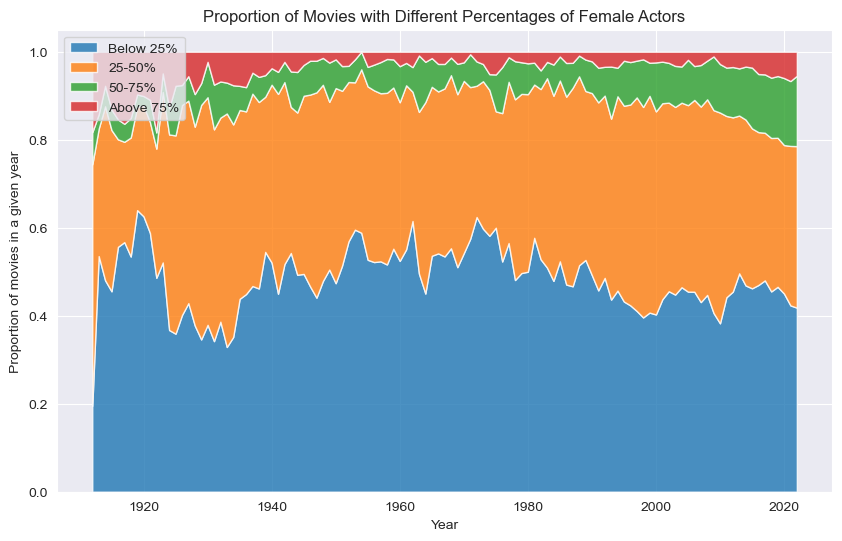

In [56]:
# Extract unique years from the 'release_date' column of the female_proportions DataFrame
unique_years = female_proportions['release_date'].unique()

# Convert the unique years to a list
years = list(unique_years)

# Data for stack plot
categories = ['Below 25%', '25-50%', '50-75%', 'Above 75%']
data = [below_25_per_year, quarter_50_per_year, half_75_per_year, above_75_per_year]

# Create a stack plot
plt.figure(figsize=(10, 6))
plt.stackplot(years, data, labels=categories, alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Proportion of movies in a given year')
plt.title('Proportion of Movies with Different Percentages of Female Actors')
plt.legend(loc='upper left')
plt.show()

We can observe that a vast majority of movies have less than 50% of women in their cast. Actually, over the years, a vast majority of movies (approximately 80%) have less than 50% female actors in their cast. Thus, even though overall the proportion of women seems to be close to 40% over the years, their are largely underrepresented in the vast majority of movies.

**What's the age difference of female actors in movies compared to male actors over the years? Are female actors significantly younger than male actors?**

In [57]:
# drop the actors with NaN as age but also actors with negative ages (which appeared in 1910)
character_age = characters_data.dropna(subset=['actor_age']).copy()
character_age = character_age[character_age['actor_age'] >= 0] # remove actors with a negative age

In [58]:
# Group by year and gender
characters_age_by_year_gender = character_age.groupby([character_age['release_date'], 'actor_gender'])

# Calculate average age and standard deviation of age for each gender per year
gender_age_stats_per_year = characters_age_by_year_gender['actor_age'].agg(['mean', 'sem'])

# Reset the index to make the grouped columns accessible for further analysis or visualization
gender_age_stats_per_year.reset_index(inplace=True)


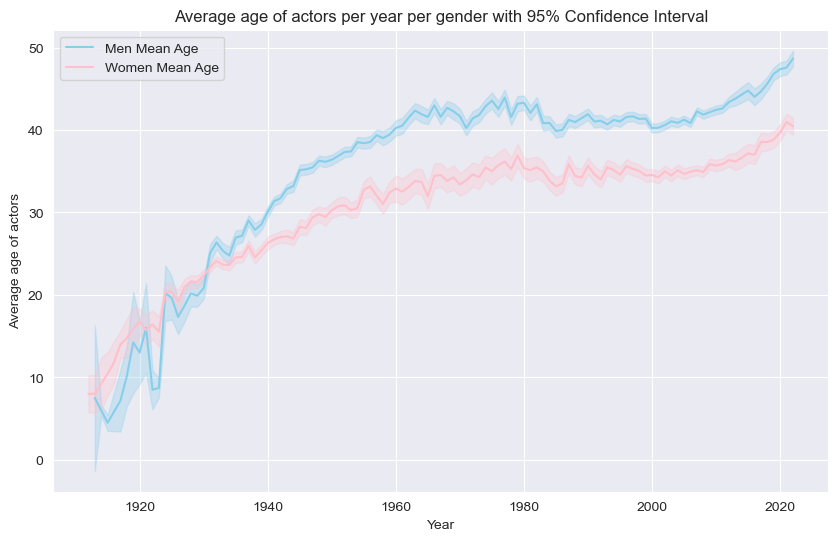

In [59]:
# Filter data for men and women separately for easier handling
men_data = gender_age_stats_per_year[gender_age_stats_per_year['actor_gender'] == 'M'].copy()
women_data = gender_age_stats_per_year[gender_age_stats_per_year['actor_gender'] == 'F'].copy()

# Calculate 95% confidence interval for men
men_data['lower_bound'] = men_data['mean'] - 1.96 * men_data['sem']
men_data['upper_bound'] = men_data['mean'] + 1.96 * men_data['sem']

# Calculate 95% confidence interval for women
women_data['lower_bound'] = women_data['mean'] - 1.96 * women_data['sem']
women_data['upper_bound'] = women_data['mean'] + 1.96 * women_data['sem']

# Plotting for men
plt.figure(figsize=(10, 6))
plt.plot(men_data['release_date'], men_data['mean'], label='Men Mean Age', color='skyblue')
plt.fill_between(men_data['release_date'], men_data['lower_bound'], men_data['upper_bound'], alpha=0.3, color='skyblue')

# Plotting for women
plt.plot(women_data['release_date'], women_data['mean'], label='Women Mean Age', color='pink')
plt.fill_between(women_data['release_date'], women_data['lower_bound'], women_data['upper_bound'], alpha=0.3, color='pink')
plt.xlabel('Year')
plt.ylabel('Average age of actors')
plt.title('Average age of actors per year per gender with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

Throughout the years, female actors are significantly younger than men at the 5% significance level.


**TO DO: MERGE WITH THE PERSONNAS TO ANALYSE**
regarder les roles opposés (dumb blonde vs genius) et voir si plus représenté dans un genre + enlever les genre ou ça fait pas sens de comparer genre (e.g. films de guerre, documentaires... car ce sont des évènements historique donc on peut rien y faire))

## Personas Analysis

**What personnas are associated with movie characters interpreted by male and female actors? Are female characters (so female actors) mostly associated woth beauty, stupidity, weakness and sexualized and men mostly associated with heroism, adventure, strenght...?**

In [60]:
# For the following analysis, drop all the characters that don't have personnas
characters_data_personnas_noNA = characters_data.dropna(subset=['personnas']).copy()
display(characters_data_personnas_noNA)

,wikipedia_ID,freebase_ID,release_date,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID,personnas,name,IMDB_ID,actor_IMDB_ID,character_name
370,196176.0,/m/01bwgr,1971.0,1937-08-08,M,1.66,/m/041rx,dustin hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,straw dogs,NaN,NaN,david sumner
1503,1157158.0,/m/04c13q,2002.0,1969-08-18,M,1.83,NaN,edward norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,death to smoochy,NaN,NaN,sheldon mopes
1866,504242.0,/m/02j9_2,2005.0,1978-05-15,M,1.68,/m/041rx,david krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,serenity,NaN,NaN,mr. universe
2221,6917005.0,/m/0gwypk,2003.0,1962-03-21,M,1.73,/m/041rx,matthew broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer,the music man,NaN,NaN,harold hill
2832,445066.0,/m/0299hs,1987.0,1938-07-23,M,1.88,NaN,ronny cox,48.0,/m/0k2m8v,/m/0h5q83s,/m/032qgs,corrupt_corporate_executive,robocop,NaN,NaN,dick jones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222527,2688769.0,/m/07y2zw,1990.0,1962-11-14,F,1.57,NaN,laura san giacomo,27.0,/m/02tb5g1,/m/0h32zqz,/m/0300lh,ophelia,quigley down under,NaN,NaN,crazy cora
223302,101954.0,/m/0pv3x,1996.0,1960-09-10,M,1.87,/m/0d7wh,colin firth,36.0,/m/0k4_tz,/m/0c0fwm8,/m/03f1zdw,crazy_jealous_guy,the english patient,NaN,NaN,geoffrey clifton
223481,9513043.0,/m/02ph9tm,2008.0,1966-09-09,M,1.78,/m/041rx,adam sandler,41.0,/m/03hqx35,/m/0cb03np,/m/0pz91,warrior_poet,you don't mess with the zohan,NaN,NaN,zohan
225604,52549.0,/m/0dtfn,1977.0,1942-07-13,M,1.85,/m/01qhm_,harrison ford,34.0,/m/0k3r1_,/m/0fjn8,/m/0c0k1,charmer,star wars episode iv: a new hope,NaN,NaN,han solo


From the size of the datasets, we can see that one personnas has been dropped because there were no matches between the freebase_character_actor_mapID in the characters data.


In [61]:
# Check values in the "actor_gender" column to make sure it is populated
characters_data_personnas_noNA.loc[characters_data_personnas_noNA.actor_gender.isna(), "actor_gender"] = "NA"
display(characters_data_personnas_noNA.groupby("actor_gender").count().actor_name)

actor_gender
F     59
M    359
Name: actor_name, dtype: int64

From this very simple line, we can already see that out of the 500 characters, only 69 are played by women, which is already a poor representation.

In [62]:
# split the dataframe in 2: one for males and one for women, which is easier for the subsequent analysis
male_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'M'].copy()
female_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'F'].copy()

In [63]:
# print the female personnas with their number of occurance
unique_female_personnas_counts = female_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_female_personnas_counts = unique_female_personnas_counts.sort_values(ascending=False)
sorted_female_personnas_counts

personnas
dumb_blonde                 9
brainless_beauty            7
final_girl                  6
chanteuse                   6
prima_donna                 5
granola_person              4
broken_bird                 4
valley_girl                 3
ophelia                     3
eccentric_mentor            2
junkie_prophet              2
doormat                     1
adventurer_archaeologist    1
storyteller                 1
klutz                       1
heartbroken_badass          1
ditz                        1
classy_cat_burglar          1
bully                       1
Name: count, dtype: int64

In [64]:
# Do the same for men
unique_male_personnas_counts = male_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_male_personnas_counts = unique_male_personnas_counts.sort_values(ascending=False)
print(sorted_male_personnas_counts.head(20))

personnas
corrupt_corporate_executive    23
crazy_jealous_guy              21
psycho_for_hire                14
father_to_his_men              13
byronic_hero                   13
stoner                         11
master_swordsman                9
hitman_with_a_heart             9
arrogant_kungfu_guy             8
bounty_hunter                   8
evil_prince                     7
fastest_gun_in_the_west         7
dirty_cop                       7
hardboiled_detective            7
surfer_dude                     6
retired_outlaw                  6
young_gun                       6
egomaniac_hunter                6
tranquil_fury                   6
big_man_on_campus               6
Name: count, dtype: int64


In [65]:
# Extract the index (unique 'personnas') from both DataFrames
female_personnas = sorted_female_personnas_counts.index
male_personnas = sorted_male_personnas_counts.index

# Find the intersection between the two sets of 'personnas'
common_personnas = set(female_personnas) & set(male_personnas)

# Create a list of with the common personnas and their count in the male and female data
common_personnas_data = [
    {
        'personna': personna,
        'female_count': sorted_female_personnas_counts.get(personna, 0),
        'male_count': sorted_male_personnas_counts.get(personna, 0),
        'association_with_F_compared_to_M' : (sorted_female_personnas_counts.get(personna, 0)/len(female_personnas_data)) / (sorted_male_personnas_counts.get(personna, 0)/len(male_personnas_data))
    }
    for personna in common_personnas
]

# Create a DataFrame from the list of dictionaries
common_personnas_df = pd.DataFrame(common_personnas_data)
display(common_personnas_df)

,personna,female_count,male_count,association_with_F_compared_to_M
0,eccentric_mentor,2,3,4.056497
1,adventurer_archaeologist,1,3,2.028249
2,storyteller,1,3,2.028249
3,brainless_beauty,7,4,10.648305
4,bully,1,2,3.042373
5,heartbroken_badass,1,2,3.042373
6,klutz,1,1,6.084746
7,broken_bird,4,1,24.338983
8,ditz,1,5,1.216949
9,doormat,1,3,2.028249


This dataframe shows which personnas are common for male and female as well as the count of each gender. The last colomn normalizes the counts to be able to compare them between females and males (as there are 69 females vs 431 males). It is sticking how "dumb_blond" is more than 64 times more for associated with women than men. Overall, terms with a bad connotation (broken_bird, dumb_blonde, brainless_beauty or bully) are much more associated to women than men. However, it is important to remember that the analysis is made only on 500 characters.

